## Import the Model

In [ ]:

import tensorflow as tf
tf.enable_eager_execution()

In [2]:
from tensorflow.python.keras.applications.vgg19 import VGG19

In [4]:
model= VGG19(
    include_top=False,
    weights='imagenet'
)
model.trainable=False
model.summary()


80142336/80134624 [==============================] - 1068s 13us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_

In [5]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Image Processing and Display

In [6]:
def load_and_process_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img,axis=0)
    return img

In [7]:
def deprocess(x):
    x[:,:,0] +=103.939
    x[:,:,1] +=116.779
    x[:,:,2] +=123.68
    
    x= x[:,:,::-1]
    
    x= np.clip(x,0,255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4:
        img= np.squeeze(image,axis=0)
        
    img = deprocess(img)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

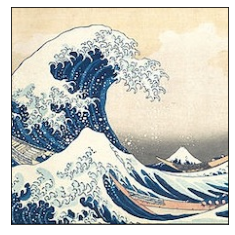

In [8]:
display_image(load_and_process_image('style.jpg'))

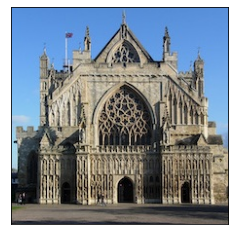

In [9]:
display_image(load_and_process_image('content.jpg'))

## Content and Style Models

In [10]:
content_layer = 'block5_conv2'

style_layers = [
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]

content_model = Model(
    inputs  =  model.input,
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(inputs = model.input,
                     outputs = model.get_layer(layer).output) for layer in style_layers]



## Content Cost

In [11]:
def content_cost(content,generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    
    cost= tf.reduce_mean(tf.square(a_C-a_G))
    return cost

## Gram Matrix

In [12]:
def gram_matrix(A):
    n_C = int(A.shape[-1])
    a=tf.reshape(A,[-1,n_C])
    n=tf.shape(a)[0]
    
    G= tf.matmul(a,a,transpose_a=True)
    return G/tf.cast(n,tf.float32)

## Style Cost

In [14]:
lam = 1./len(style_models)

def style_cost(style,generated):
    J_style=0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        
        current_cost = tf.reduce_mean(tf.square(GS-GG))
        
        J_style += current_cost * lam
    return J_style

## Training Loop

In [15]:
import time
generated_images = []

def training_loop(content_path,style_path,iterations=20,
                 alpha=10.,beta=20.):
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    
    generated = tf.contrib.eager.Variable(content, dtype=tf.float32)
    
    opt = tf.train.AdamOptimizer(learning_rate= 5.)
    
    best_cost=1e12+0.1
    best_image = None
    
    start_time= time.time()
    
    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = alpha * J_content+ beta* J_style
            
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads,generated)])

        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()

        print('Cost at {}: {}. Time elapsed: {}'.format(i,J_total,time.time()-start_time))
        generated_images.append(generated.numpy())
    return best_image

In [16]:
best_image = training_loop('content.jpg','style.jpg')

Cost at 0: 13316817920.0. Time elapsed: 13.88229775428772
Cost at 1: 9373819904.0. Time elapsed: 26.831451892852783
Cost at 2: 6242040320.0. Time elapsed: 39.6656973361969
Cost at 3: 4608433152.0. Time elapsed: 52.64387512207031
Cost at 4: 3832281600.0. Time elapsed: 65.46925020217896
Cost at 5: 3249929984.0. Time elapsed: 76.0330240726471
Cost at 6: 2793248512.0. Time elapsed: 84.1492600440979
Cost at 7: 2498315520.0. Time elapsed: 92.317617893219
Cost at 8: 2295301376.0. Time elapsed: 100.02457213401794
Cost at 9: 2113441664.0. Time elapsed: 107.87055349349976
Cost at 10: 1933081984.0. Time elapsed: 115.64635467529297
Cost at 11: 1763715328.0. Time elapsed: 123.74267244338989
Cost at 12: 1614687104.0. Time elapsed: 132.45096373558044
Cost at 13: 1484460800.0. Time elapsed: 141.91196465492249
Cost at 14: 1363932928.0. Time elapsed: 153.40914273262024
Cost at 15: 1251754112.0. Time elapsed: 162.93419218063354
Cost at 16: 1153507456.0. Time elapsed: 171.1666886806488
Cost at 17: 1071486

## Plot the Results

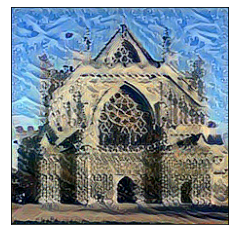

In [17]:
display_image(best_image)